# Make wav list
- 파일을 tr, cv, tt 폴더별로 무지성으로 읽어온 다음 각 폴더별 list를 .lst 파일로 만듦

In [1]:
"""
tr_wav.lst format:
...
447o030v_0.1232_050c0109_-0.1232.wav
447o030v_1.7882_444o0310_-1.7882.wav
447o030w_0.52605_446o030e_-0.52605.wav
447o030w_1.9272_420c0203_-1.9272.wav
447o030x_0.03457_441c0209_-0.03457.wav
447o030x_0.70879_420o0307_-0.70879.wav
447o030x_0.98832_441o0308_-0.98832.wav
447o030x_1.4783_422o030p_-1.4783.wav
...
"""
import os
import argparse

wav_dir = './mycode/wsj0_2mix/use_this/'
list_dir = './mycode/wsj0_2mix/use_this/lists/'

wav_dir = wav_dir
output_lst = list_dir

for folder in ['tr', 'cv', 'tt']:
    wav_files = os.listdir(wav_dir + folder)
    output_lst_files = output_lst + folder + '_wav.lst'
    with open(output_lst_files, 'w') as f:
        for file in wav_files:
            f.write(file + "\n")

print("Generate wav file to .lst done!")

Generate wav file to .lst done!


# Make TFRecord file

- 여기서는 위에서 만든 리스트 파일을 가지고 tfrecord data로 변환함
- 이 섹션의 맨 아래 블럭의 코드가 본 코드인데, 읽어들인 raw data를 stft하고, stft한거를 입력으로 세팅함
- 그리고 mix된 stft data를 통해서 label들을 뽑아내고, 따로 gender값도 읽어들임
- 이렇게 얻게된 3개의 값(mix_stft, labels, gender)을 TFRecord 형식으로 저장함

In [2]:
import tensorflow as tf
import string

import multiprocessing
import tensorflow as tf
import numpy as np
import librosa
from scipy import signal
import argparse
import os, sys
from numpy.fft import rfft, irfft
from scipy.io.wavfile import write as wav_write

In [3]:
def mkdir_p(path):
    """ Creates a path recursively without throwing an error if it already exists
    :param path: path to create
    :return: None
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
def segment_axis(a, length, overlap=0, axis=None, end='cut', endvalue=0):
    """Generate a new array that chops the given array along the given axis into overlapping frames.
    example:
    >>> segment_axis(np.arange(10), 4, 2)
    array([[0, 1, 2, 3],
           [2, 3, 4, 5],
           [4, 5, 6, 7],
           [6, 7, 8, 9]])
    arguments:
    a       The array to segment
    length  The length of each frame
    overlap The number of array elements by which the frames should overlap
    axis    The axis to operate on; if None, act on the flattened array
    end     What to do with the last frame, if the array is not evenly
            divisible into pieces. Options are:
            'cut'   Simply discard the extra values
            'wrap'  Copy values from the beginning of the array
            'pad'   Pad with a constant value
    endvalue    The value to use for end='pad'
    The array is not copied unless necessary (either because it is
    unevenly strided and being flattened or because end is set to
    'pad' or 'wrap').
    """

    if axis is None:
        a = np.ravel(a)  # may copy
        axis = 0

    l = a.shape[axis]

    if overlap >= length: raise ValueError(
        "frames cannot overlap by more than 100%")
    if overlap < 0 or length <= 0: raise ValueError(
        "overlap must be nonnegative and length must be positive")

    if l < length or (l - length) % (length - overlap):
        if l > length:
            roundup = length + (1 + (l - length) // (length - overlap)) * (
                    length - overlap)
            rounddown = length + ((l - length) // (length - overlap)) * (
                    length - overlap)
        else:
            roundup = length
            rounddown = 0
        assert rounddown < l < roundup
        assert roundup == rounddown + (length - overlap) or (
                roundup == length and rounddown == 0)
        a = a.swapaxes(-1, axis)

        if end == 'cut':
            a = a[..., :rounddown]
        elif end in ['pad', 'wrap']:  # copying will be necessary
            s = list(a.shape)
            s[-1] = roundup
            b = np.empty(s, dtype=a.dtype)
            b[..., :l] = a
            if end == 'pad':
                b[..., l:] = endvalue
            elif end == 'wrap':
                b[..., l:] = a[..., :roundup - l]
            a = b

        a = a.swapaxes(-1, axis)

    l = a.shape[axis]
    if l == 0: raise ValueError(
        "Not enough data points to segment array in 'cut' mode; try 'pad' or 'wrap'")
    assert l >= length
    assert (l - length) % (length - overlap) == 0
    n = 1 + (l - length) // (length - overlap)
    s = a.strides[axis]
    newshape = a.shape[:axis] + (n, length) + a.shape[axis + 1:]
    newstrides = a.strides[:axis] + ((length - overlap) * s, s) + a.strides[axis + 1:]

    if not a.flags.contiguous:
        a = a.copy()
        newstrides = a.strides[:axis] + ((length - overlap) * s, s) + a.strides[axis + 1:]
        return np.ndarray.__new__(np.ndarray, strides=newstrides, shape=newshape, buffer=a, dtype=a.dtype)

    try:
        return np.ndarray.__new__(np.ndarray, strides=newstrides, shape=newshape, buffer=a, dtype=a.dtype)
    except TypeError or ValueError:
        warnings.warn("Problem with ndarray creation forces copy.")
        a = a.copy()
        # Shape doesn't change but strides does
        newstrides = a.strides[:axis] + ((length - overlap) * s, s) + a.strides[axis + 1:]
        return np.ndarray.__new__(np.ndarray, strides=newstrides, shape=newshape, buffer=a, dtype=a.dtype)

In [5]:
def _samples_to_stft_frames(samples, size, shift):
    """
    Calculates STFT frames from samples in time domain.
    :param samples: Number of samples in time domain.
    :param size: FFT size.
    :param shift: Hop in samples.
    :return: Number of STFT frames.
    """

    return np.ceil((float(samples) - size + shift) / shift).astype(np.int)

In [6]:
def _stft_frames_to_samples(frames, size, shift):
    """
    Calculates samples in time domain from STFT frames
    :param frames: Number of STFT frames.
    :param size: FFT size.
    :param shift: Hop in samples.
    :return: Number of samples in time domain.
    """
    return frames * shift + size - shift

In [7]:
def stft(time_signal, time_dim=None, size=1024, shift=256,
         window=signal.blackman, fading=True, window_length=None):
    """
    Calculates the short time Fourier transformation of a multi channel multi
    speaker time signal. It is able to add additional zeros for fade-in and
    fade out and should yield an STFT signal which allows perfect
    reconstruction.
    :param time_signal: multi channel time signal.
    :param time_dim: Scalar dim of time.
        Default: None means the biggest dimension
    :param size: Scalar FFT-size.
    :param shift: Scalar FFT-shift. Typically shift is a fraction of size.
    :param window: Window function handle.
    :param fading: Pads the signal with zeros for better reconstruction.
    :param window_length: Sometimes one desires to use a shorter window than
        the fft size. In that case, the window is padded with zeros.
        The default is to use the fft-size as a window size.
    :return: Single channel complex STFT signal
        with dimensions frames times size/2+1.
    """
    if time_dim is None:
        time_dim = np.argmax(time_signal.shape)

    # Pad with zeros to have enough samples for the window function to fade.
    if fading:
        pad = [(0, 0)] * time_signal.ndim
        pad[time_dim] = [size - shift, size - shift]
        time_signal = np.pad(time_signal, pad, mode='constant')

    # Pad with trailing zeros, to have an integral number of frames.
    frames = _samples_to_stft_frames(time_signal.shape[time_dim], size, shift)
    samples = _stft_frames_to_samples(frames, size, shift)
    pad = [(0, 0)] * time_signal.ndim
    pad[time_dim] = [0, samples - time_signal.shape[time_dim]]
    time_signal = np.pad(time_signal, pad, mode='constant')
    

    if window_length is None:
        window = window(size)
    else:
        window = window(window_length)
        window = np.pad(window, (0, size - window_length), mode='constant')

    time_signal_seg = segment_axis(time_signal, size,
                                   size - shift, axis=time_dim)

    letters = string.ascii_lowercase
    mapping = letters[:time_signal_seg.ndim] + ',' + letters[time_dim + 1] \
              + '->' + letters[:time_signal_seg.ndim]

    return rfft(np.einsum(mapping, time_signal_seg, window), axis=time_dim + 1)

In [8]:
def audioread(path, offset=0.0, duration=None, sample_rate=16000):
    """
    Reads a wav file, converts it to 32 bit float values and reshapes accoring
    to the number of channels.
    Now, this is a wrapper of librosa with our common defaults.
    :param path: Absolute or relative file path to audio file.
    :type: String.
    :param offset: Begin of loaded audio.
    :type: Scalar in seconds.
    :param duration: Duration of loaded audio.
    :type: Scalar in seconds.
    :param sample_rate: Sample rate of audio
    :type: scalar in number of samples per second
    :return:
    """
    signal = librosa.load(path, sr=sample_rate, mono=False, offset=offset, duration=duration)
    
    return signal[0]

In [72]:
import librosa.display

sys.path.append('.')

wav_dir = './mycode/wsj0_2mix/use_this/'
list_dir = './mycode/wsj0_2mix/use_this/lists/'
tfrecord_dir = './mycode/tfrecords/'
gender_list = './wsj0-train-spkrinfo.txt'
process_num = 8

mkdir_p(tfrecord_dir) # tfrecord_dir 폴더 만드는 코드
sample_rate = 8000
window_size = 256
window_shift = 128

if gender_list is not '':
    apply_gender_info = True
    gender_dict = {}
    fid = open(gender_list, 'r')
    lines = fid.readlines()
    fid.close()
    for line in lines:
        spk = line.strip('\n').split(' ')[0]
        gender = line.strip('\n').split(' ')[1]
        if gender.lower() == 'm':
            gender_dict[spk] = 1
        else:
            gender_dict[spk] = 0


def make_sequence_example(inputs, labels, genders):
    input_features = [tf.train.Feature(float_list=tf.train.FloatList(value=input_)) for input_ in inputs]
    label_features = [tf.train.Feature(float_list=tf.train.FloatList(value=label)) for label in labels]
    gender_features = [tf.train.Feature(float_list=tf.train.FloatList(value=genders))]
    
    feature_list = {
        'inputs': tf.train.FeatureList(feature=input_features),
        'labels': tf.train.FeatureList(feature=label_features),
        'genders': tf.train.FeatureList(feature=gender_features)
    }
    feature_lists = tf.train.FeatureLists(feature_list=feature_list)
    
    return tf.train.SequenceExample(feature_lists=feature_lists)


def gen_feats(wav_name, sample_rate, window_size, window_shift, file):
    mix_wav_name = wav_dir + '/mix/' + wav_name
    s1_wav_name  = wav_dir + '/s1/' + wav_name
    s2_wav_name  = wav_dir + '/s2/' + wav_name

    mix_wav = audioread(mix_wav_name, offset=0.0, duration=None, sample_rate=sample_rate)
    s1_wav  = audioread(s1_wav_name,  offset=0.0, duration=None, sample_rate=sample_rate)
    s2_wav  = audioread(s2_wav_name,  offset=0.0, duration=None, sample_rate=sample_rate)

    mix_stft = stft(mix_wav, time_dim=0, size=window_size, shift=window_shift)
    s1_stft  = stft(s1_wav,  time_dim=0, size=window_size, shift=window_shift)
    s2_stft  = stft(s2_wav,  time_dim=0, size=window_size, shift=window_shift)
    
#     mix2_stft = librosa.stft(mix_wav, n_fft=window_size, hop_length=window_shift, window=signal.blackman)
#     db = librosa.amplitude_to_db(np.transpose(np.abs(s2_stft)),ref=np.max)
#     db2 = librosa.amplitude_to_db(np.abs(mix2_stft),ref=np.max)
#     librosa.display.specshow(db, sr=sample_rate, y_axis='linear', x_axis='time')
#     librosa.display.specshow(db2, sr=sample_rate, y_axis='log', x_axis='time')
#     print(np.transpose(np.abs(mix_stft)).shape)

    s1_gender = gender_dict[wav_name.split('_')[0][0:3]]
    s2_gender = gender_dict[wav_name.split('_')[2][0:3]]

    part_name = os.path.splitext(wav_name)[0]
    tfrecords_name = tfrecord_dir + file + '_tfrecord\\' + part_name + '.tfrecords'
    #print(tfrecords_name)

    with tf.io.TFRecordWriter(tfrecords_name) as writer:
        tf.compat.v1.logging.info("Writing utterance %s" %tfrecords_name)

        mix_abs = np.abs(mix_stft)
        mix_angle = np.angle(mix_stft)

        s1_abs = np.abs(s1_stft)
        s1_angle = np.angle(s1_stft)

        s2_abs = np.abs(s2_stft)
        s2_angle = np.angle(s2_stft)

        inputs = np.concatenate((mix_abs, mix_angle), axis=1)
        labels = np.concatenate((s1_abs * np.cos(mix_angle - s1_angle), s2_abs * np.cos(mix_angle - s2_angle)), axis=1)
        gender = [s1_gender, s2_gender]
        
#         print(inputs.shape)
#         print(mix_abs)
#         print(labels.shape)
#         print(np.array(gender).shape)

        ex = make_sequence_example(inputs, labels, gender)
        writer.write(ex.SerializeToString())


# 여기 멀티프로세싱 pool 적용 어케하는지 모르게씀
for files in ['tr', 'cv', 'tt']:
#     pool = multiprocessing.Pool(processes=process_num)
    output_lst_files = list_dir + files + '_wav.lst'
    fid = open(output_lst_files, 'r')
    lines = fid.readlines()
    fid.close()
    
    mkdir_p(tfrecord_dir + files + '_tfrecord') # tfrecord_dir 폴더 만드는 코드
    for name in lines:
        name = name.strip('\n')
#         pool.map_async(gen_feats, (name, sample_rate, window_size, window_shift, files))
        gen_feats(name, sample_rate, window_size, window_shift, files)
#     pool.close()
#     pool.join()

print('Done')

INFO:tensorflow:Writing utterance ./mycode/tfrecords/tr_tfrecord\447o0302_0.62948_441c0212_-0.62948.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/tr_tfrecord\447o0302_1.3388_22ho010i_-1.3388.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/tr_tfrecord\447o0302_2.1067_422o030k_-2.1067.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/tr_tfrecord\447o0303_0.14144_441c0212_-0.14144.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/cv_tfrecord\447o0302_0.62948_441c0212_-0.62948.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/cv_tfrecord\447o0302_1.3388_22ho010i_-1.3388.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/cv_tfrecord\447o0302_2.1067_422o030k_-2.1067.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/cv_tfrecord\447o0303_0.14144_441c0212_-0.14144.tfrecords
INFO:tensorflow:Writing utterance ./mycode/tfrecords/tt_tfrecord\447o0302_0.62948_441c0212_-0.62948.tfrecords
INFO:tensorflow:Wr

# Deep learning part
## 1. Data Loader
- Data를 시바 읽어오자

In [18]:
import tensorflow as tf
from functools import partial
import logging

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 25
INPUT_SIZE = 129
OUTPUT_SIZE = 129

In [20]:
# Load the data

tr_path = './mycode/tfrecords/tr_tfrecord/*.tfrecords'
val_path = './mycode/tfrecords/cv_tfrecord/*.tfrecords'
tt_path = './mycode/tfrecords/tt_tfrecord/*.tfrecords'

FILENAMES_TRAINING = tf.io.gfile.glob(tr_path)
FILENAMES_VALIDATION = tf.io.gfile.glob(val_path)
FILENAMES_TEST = tf.io.gfile.glob(tt_path)

In [21]:
print("Train TFRecord Files:", len(FILENAMES_TRAINING))
print("Validation TFRecord Files:", len(FILENAMES_VALIDATION))
print("Test TFRecord Files:", len(FILENAMES_TEST))
FILENAMES_TRAINING

Train TFRecord Files: 4
Validation TFRecord Files: 4
Test TFRecord Files: 4


['.\\mycode\\tfrecords\\tr_tfrecord\\447o0302_0.62948_441c0212_-0.62948.tfrecords',
 '.\\mycode\\tfrecords\\tr_tfrecord\\447o0302_1.3388_22ho010i_-1.3388.tfrecords',
 '.\\mycode\\tfrecords\\tr_tfrecord\\447o0302_2.1067_422o030k_-2.1067.tfrecords',
 '.\\mycode\\tfrecords\\tr_tfrecord\\447o0303_0.14144_441c0212_-0.14144.tfrecords']

In [22]:
def data_preprocessing(data, check, input_size=129*2, output_size=129*2):
    if check == 'inputs':
        inputs = tf.slice(data, [0, 0], [-1, input_size//2])
        angle = tf.slice(data, [0, input_size//2], [-1, -1])
        
        return inputs, angle
    
    elif check == 'labels':
        label1 = tf.slice(data, [0, 0], [-1, output_size//2])
        label2 = tf.slice(data, [0, output_size//2], [-1, -1])
        
        return label1, label2

In [23]:
def read_tfrecord(example, input_size=129*2, output_size=129*2):
    tfrecord_format = (
        {
            'inputs': tf.io.FixedLenSequenceFeature(shape=[input_size], dtype=tf.float32, allow_missing=True),
            'labels': tf.io.FixedLenSequenceFeature(shape=[output_size], dtype=tf.float32, allow_missing=True),
            'genders': tf.io.FixedLenSequenceFeature(shape=[2], dtype=tf.float32, allow_missing=True)
        }
    )
    _, example = tf.io.parse_single_sequence_example(example, sequence_features=tfrecord_format)
    inputs, angle = data_preprocessing(example["inputs"], 'inputs', input_size)
#     label1, label2 = data_preprocessing(example["labels"], 'labels', input_size)
    
    return inputs, example['labels']

In [24]:
def read_tfrecord_test(example, input_size=129*2, output_size=129*2):
    tfrecord_format = (
        {
            'inputs': tf.io.FixedLenSequenceFeature(shape=[input_size], dtype=tf.float32, allow_missing=True),
            'labels': tf.io.FixedLenSequenceFeature(shape=[output_size], dtype=tf.float32, allow_missing=True),
            'genders': tf.io.FixedLenSequenceFeature(shape=[2], dtype=tf.float32, allow_missing=True)
        }
    )
    _, example = tf.io.parse_single_sequence_example(example, sequence_features=tfrecord_format)
    inputs, angle = data_preprocessing(example["inputs"], 'inputs', input_size)
    
    return inputs, angle, example['labels']

In [25]:
def load_dataset(filenames, input_size=129*2, output_size=129*2, check='train'):
    ignore_order = tf.data.Options()
    
    if check == 'train':
        ignore_order.experimental_deterministic = False  # disable order, increase speed
    else:
        ignore_order.experimental_deterministic = True
    
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    
    if check == 'train':
        dataset = dataset.map(
            partial(read_tfrecord, input_size=input_size, output_size=output_size), num_parallel_calls=AUTOTUNE
        )
    else:
        dataset = dataset.map(
            partial(read_tfrecord_test, input_size=input_size, output_size=output_size), num_parallel_calls=AUTOTUNE
        )
    
    return dataset

In [26]:
def get_dataset(filenames, input_size=129*2, output_size=129*2):
    dataset = load_dataset(filenames, input_size, output_size)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(None))
    
    return dataset

In [46]:
def get_dataset_for_test(filenames, input_size=129*2, output_size=129*2):
    dataset = load_dataset(filenames, input_size, output_size, check='test')
    dataset = dataset.repeat(1)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=(None))
    
    return dataset

In [47]:
train_dataset = get_dataset(FILENAMES_TRAINING, INPUT_SIZE*2, OUTPUT_SIZE*2)
valid_dataset = get_dataset(FILENAMES_VALIDATION, INPUT_SIZE*2, OUTPUT_SIZE*2)

test_dataset = get_dataset_for_test(FILENAMES_TEST, INPUT_SIZE*2, OUTPUT_SIZE*2)

## 2. Building model

- 이제 우리 모델을 시바 개쩔게 만들자

In [29]:
import threading, sys
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Reshape, LSTM, Concatenate, Multiply, Bidirectional, Dropout
from tensorflow.keras import optimizers
from tensorflow import keras

import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [36]:
BATCH_SIZE = 25
INPUT_SIZE = 129
OUTPUT_SIZE = 129

In [31]:
mkdir_p('./CKPT/') # model check point 폴더 만드는 코드
filepath = "./CKPT/CKP_ep_{epoch:d}__loss_{val_loss:.5f}_.h5"

In [32]:
# Custom PIT loss

def pit_with_outputsize(output_size):
    def pit_loss(y_true, y_pred):
        labels1 = tf.slice(y_true, [0, 0, 0], [-1, -1, output_size])
        labels2 = tf.slice(y_true, [0, 0, output_size], [-1, -1, -1])

        pred1 = tf.slice(y_pred, [0, 0, 0], [-1, -1, output_size])
        pred2 = tf.slice(y_pred, [0, 0, output_size], [-1, -1, -1])

        cost1 = tf.reduce_mean(tf.reduce_sum(tf.pow(pred1 - labels1, 2), 1) + tf.reduce_sum(tf.pow(pred2 - labels2, 2), 1), 1)
        cost2 = tf.reduce_mean(tf.reduce_sum(tf.pow(pred2 - labels1, 2), 1) + tf.reduce_sum(tf.pow(pred1 - labels2, 2), 1), 1)

        idx = tf.cast(cost1 > cost2, tf.float32) 
        pit_loss = tf.reduce_sum(idx * cost2 + (1 - idx) * cost1)
        
        return pit_loss
    
    return pit_loss

In [33]:
# our model

def uPIT(input_size, output_size, batch):
    inputs = Input(shape=(None, input_size))
    
    outputs = Dense(496, activation = 'tanh')(inputs)
    
    outputs = Bidirectional(LSTM(496, activation = 'tanh', return_sequences=True),
                           input_shape=(None, 496,))(outputs)
    drop = Dropout(rate=0.8)(outputs)
    outputs = Bidirectional(LSTM(496, activation = 'tanh', return_sequences=True))(drop)
    drop = Dropout(rate=0.8)(outputs)
    outputs = Bidirectional(LSTM(496, activation = 'tanh', return_sequences=True))(drop)
    drop = Dropout(rate=0.8)(outputs)
    
    pred1 = Dense(output_size, activation = 'relu')(drop)
    pred2 = Dense(output_size, activation = 'relu')(drop)
    
    cleaned1 = Multiply()([pred1, inputs])
    cleaned2 = Multiply()([pred2, inputs])
    
    model = Concatenate()([cleaned1, cleaned2])
    
    model = keras.Model(inputs, model)
    
    model.summary()
    adam = tf.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=pit_with_outputsize(output_size), optimizer=adam)
#     model.compile(loss=keras.losses.mean_squared_error, optimizer=adam)

    return model

## 3. Training model
- 구축한 모델을 기반으로 딥러닝 학습을 진행하자

In [34]:
initial_learning_rate = 0.01

# learning rate를 점점 줄이는 부분
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

# validation loss에 대해서 좋은 것만 저장됨
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# early stop 하는 부분인데, validation loss에 대해서 제일 좋은 모델이 저장됨
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True
)

In [59]:
# Training part

epoch = 200

strategy = tf.distribute.MirroredStrategy()
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    # 사용 안할 때는 load_model 주석 처리 하자
#     model = load_model('./CKPT/CKP_ep_29__loss_102.63367_.h5', custom_objects={'pit_loss': pit_with_outputsize(OUTPUT_SIZE)})
    
    model = uPIT(INPUT_SIZE, OUTPUT_SIZE, BATCH_SIZE)
    tf.executing_eagerly()

history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=valid_dataset,
    shuffle=True,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 129)]  0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, None, 496)    64480       input_5[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, None, 496)    1970112     dense_12[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, None, 496)    0           lstm_12[0][0]                    
____________________________________________________________________________________________

## 4. Training and validation loss plot
- 학습한 모델의 loss값을 그래프로 그려봄

In [60]:
# Show training and validation loss graph

def graph_util(history):
    fig = plt.figure()
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(history.history['loss'], c='b')
    plt.plot(history.history['val_loss'], c='r')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper left')
    
    plt.show()

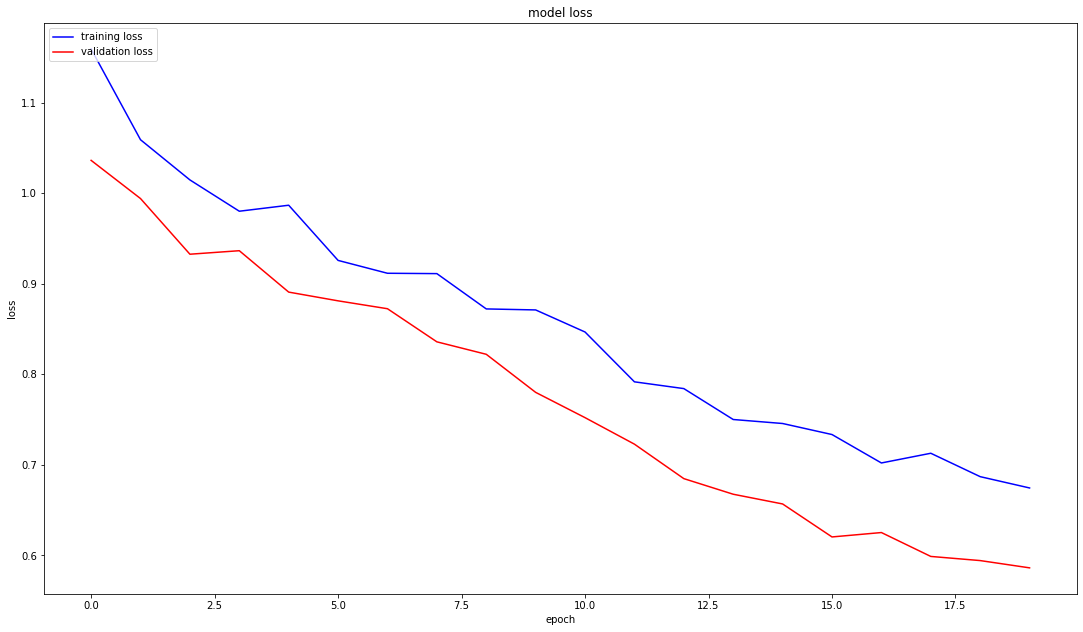

In [61]:
graph_util(history)

## 5. Test Model
- 학습된 모델을 사용해서 테스트를 진행함

In [6]:
sample_rate = 8000
window_size = 256
window_shift = 128

In [7]:
mkdir_p('./test_wav/') # Result wav 폴더 만드는 코드

In [8]:
def _biorthogonal_window_loopy(analysis_window, shift):
    """
    This version of the synthesis calculation is as close as possible to the
    Matlab impelementation in terms of variable names.
    The results are equal.
    The implementation follows equation A.92 in
    Krueger, A. Modellbasierte Merkmalsverbesserung zur robusten automatischen
    Spracherkennung in Gegenwart von Nachhall und Hintergrundstoerungen
    Paderborn, Universitaet Paderborn, Diss., 2011, 2011
    """
    fft_size = len(analysis_window)
    assert np.mod(fft_size, shift) == 0
    number_of_shifts = len(analysis_window) // shift

    sum_of_squares = np.zeros(shift)
    for synthesis_index in range(0, shift):
        for sample_index in range(0, number_of_shifts + 1):
            analysis_index = synthesis_index + sample_index * shift

            if analysis_index + 1 < fft_size:
                sum_of_squares[synthesis_index] \
                    += analysis_window[analysis_index] ** 2

    sum_of_squares = np.kron(np.ones(number_of_shifts), sum_of_squares)
    synthesis_window = analysis_window / sum_of_squares / fft_size
    return synthesis_window


In [9]:
def istft(stft_signal, size=1024, shift=256,
          window=signal.blackman, fading=True, window_length=None):
    """
    Calculated the inverse short time Fourier transform to exactly reconstruct
    the time signal.
    :param stft_signal: Single channel complex STFT signal
        with dimensions frames times size/2+1.
    :param size: Scalar FFT-size.
    :param shift: Scalar FFT-shift. Typically shift is a fraction of size.
    :param window: Window function handle.
    :param fading: Removes the additional padding, if done during STFT.
    :param window_length: Sometimes one desires to use a shorter window than
        the fft size. In that case, the window is padded with zeros.
        The default is to use the fft-size as a window size.
    :return: Single channel complex STFT signal
    :return: Single channel time signal.
    """
    assert stft_signal.shape[1] == size // 2 + 1

    if window_length is None:
        window = window(size)
    else:
        window = window(window_length)
        window = np.pad(window, (0, size - window_length), mode='constant')

    window = _biorthogonal_window_loopy(window, shift)

    # Why? Line created by Hai, Lukas does not know, why it exists.
    window *= size
    time_signal = scipy.zeros(stft_signal.shape[0] * shift + size - shift)

    for j, i in enumerate(range(0, len(time_signal) - size + shift, shift)):
        time_signal[i:i + size] += window * np.real(irfft(stft_signal[j]))

    # Compensate fade-in and fade-out
    if fading:
        time_signal = time_signal[size - shift:len(time_signal) - (size - shift)]

    return time_signal

In [10]:
def audiowrite(data, path, samplerate=16000, normalize=False, threaded=True):
    """ Write the audio data ``data`` to the wav file ``path``
    The file can be written in a threaded mode. In this case, the writing
    process will be started at a separate thread. Consequently, the file will
    not be written when this function exits.
    :param data: A numpy array with the audio data
    :param path: The wav file the data should be written to
    :param samplerate: Samplerate of the audio data
    :param normalize: Normalize the audio first so that the values are within
        the range of [INTMIN, INTMAX]. E.g. no clipping occurs
    :param threaded: If true, the write process will be started as a separate
        thread
    :return: The number of clipped samples
    """
    data = data.copy()
    int16_max = np.iinfo(np.int16).max
    int16_min = np.iinfo(np.int16).min

    if normalize:
        if not data.dtype.kind == 'f':
            data = data.astype(np.float)
        data /= np.max(np.abs(data))

    if data.dtype.kind == 'f':
        data *= int16_max

    sample_to_clip = np.sum(data > int16_max)
    if sample_to_clip > 0:
        print('Warning, clipping {} samples'.format(sample_to_clip))
    data = np.clip(data, int16_min, int16_max)
    data = data.astype(np.int16)

    if threaded:
        threading.Thread(target=wav_write, args=(path, samplerate, data)).start()
    else:
        wav_write(path, samplerate, data)

    return sample_to_clip

In [50]:
with tf.device('/gpu:0'):
    model = load_model('./CKPT/CKP_ep_20__loss_0.58620_.h5', custom_objects={'pit_loss': pit_with_outputsize(OUTPUT_SIZE)})

    cnt = 0
    for batch in test_dataset:
        input_batch, angle_batch, label_batch = batch
        tf.executing_eagerly() # requires r1.7
        angle_numpy = tf.constant(angle_batch)
        angle_numpy = angle_numpy.numpy()

        result = model.predict(input_batch)
        label1 = tf.slice(result, [0, 0, 0], [-1, -1, OUTPUT_SIZE])
        label2 = tf.slice(result, [0, 0, OUTPUT_SIZE], [-1, -1, -1])
        spec1 = label1 * np.exp(angle_numpy * 1j)
        spec2 = label2 * np.exp(angle_numpy * 1j)

        num = cnt * BATCH_SIZE
        for i in range(BATCH_SIZE):
            if i >= input_batch.shape[0]:
                sys.exit(0)
            
            wav_name1 = './test_wav/' + str(i + num) + 'th_1.wav'
            wav_name2 = './test_wav/' + str(i + num) + 'th_2.wav'
            wav1 = istft(spec1[i, 0:input_batch[i].shape[0], :], size=window_size, shift=window_shift)
            wav2 = istft(spec2[i, 0:input_batch[i].shape[0], :], size=window_size, shift=window_shift)
            audiowrite(wav1, wav_name1, sample_rate, True, True)
            audiowrite(wav2, wav_name2, sample_rate, True, True)

        if (cnt + 1) % 10 == 0:
            print((cnt + 1) * BATCH_SIZE)

        cnt += 1

c:\users\moon\anaconda3\envs\study\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
